In [1]:
!pip install --upgrade keras -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.5 MB/s eta 0:00:00


In [2]:
import keras
from keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


In [3]:
learning_rate = 0.001 # 学習率
weight_decay = 0.0001 # オプティマイザーの重み減衰率
batch_size = 128 # ミニバッチのサイズ
num_epochs = 150 # 学習回数


In [4]:
# CIFAR-100をトレーニングデータとテストデータに分けてダウンロード
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

val_split = 0.1 # 検証データの割合
val_indices = int(len(x_train) * val_split) # 検証データのインデックス数を計算
# 検証データを分割して新しいトレーニングデータを作成
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices] # 検証データを抽出

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


In [5]:
image_size = 32 # 画像サイズを設定
auto = tf.data.AUTOTUNE # データの並列処理を自動にする

# データ拡張のためのレイヤーをリストにする
augmentation_layers = [
    keras.layers.RandomCrop(image_size, image_size), # ランダムに切り抜く
    keras.layers.RandomFlip("horizontal"), # 左右反転
]

def augment_images(images):
    """ 画像にデータ拡張を適用する

    Args:
        images: 入力画像のテンソル
    Returns:
        images: データ拡張が適用された画像テンソル
    """
    # データ拡張レイヤーを順番に適用
    for layer in augmentation_layers:
        images = layer(images, training=True)
    return images

def make_datasets(images, labels, is_train=False):
    """ データセットを作成する

    Args:
        images (ndarray): 画像データ
        labels (ndarray): ラベルデータ
        is_train (bool): トレーニングデータかどうかを示すフラグ
    Returns:
        作成されたデータセット
    """
    # 画像とラベルのデータセットを作成
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # トレーニングデータはシャッフルして抽出
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    # データセットをバッチサイズに分ける
    dataset = dataset.batch(batch_size)
    # トレーニングデータにはデータ拡張を適用
    if is_train:
        dataset = dataset.map(
            lambda x, y: (augment_images(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto) # データセットを高速で読み込む

# トレーニングデータを作成、データ拡張を適用
train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
# 検証データを作成
val_dataset = make_datasets(x_val, y_val)
# テストデータを作成する
test_dataset = make_datasets(x_test, y_test)



In [6]:
def activation_block(x):
    """ 活性化関数とバッチ正規化レイヤーで構成されるブロック

    Args:
        x : 入力テンソル
    Returns:
        x: 活性化関数とバッチ正規化が適用されたテンソル
    """
    x = layers.Activation("gelu")(x) # GELU活性化関数を適用

    return layers.BatchNormalization()(x) # バッチ正規化を適用

def conv_stem(x, filters: int, patch_size: int):
    """ 畳み込み層を適用し、入力画像をパッチに分割する

    Args:
        x (tf.Tensor): 画像のテンソル
        filters (int): 畳み込みフィルターの数
        patch_size (int): パッチサイズ

    Returns:
        x(tf.Tensor): 畳み込みでパッチに分割後、activation_blockが
                      適用されたテンソル
    """
    # 指定されたフィルター数とパッチサイズを用いて、パッチに分割
    # パッチ分割後: (bs, パッチの高さ, パッチの幅, チャンネル数(=フィルター数))
    x = layers.Conv2D(
        filters,
        kernel_size=patch_size,
        strides=patch_size)(x)

    # activation_blockを適用して返す
    return activation_block(x)

def conv_mixer_block(x, filters: int, kernel_size: int):
    """ ConvMixerブロック
        Depthwise畳み込みとPointwise畳み込みを適用し、activation_blockを通す

    Args:
        x (tf.Tensor): 入力テンソル
        filters (int): 畳み込みフィルターの数
        kernel_size (int): Depthwise畳み込みのカーネルサイズ

    Returns:
        tf.Tensor: ConvMixerブロックが適用されたテンソル
    """
    x0 = x # 入力直後のxを保存
    # Depthwise畳み込みを適用
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    # xにactivation_blockを適用し、元の入力x0を足し合わせて残差接続を行う
    x = layers.Add()([activation_block(x), x0])

    # Pointwise畳み込みを適用
    x = layers.Conv2D(filters, kernel_size=1)(x)
    # activation_blockを適用
    x = activation_block(x)

    return x

def get_conv_mixer_256_8(
    image_size=32,
    filters=256,
    depth=8,
    kernel_size=5,
    patch_size=2,
    num_classes=100
):
    """ ConvMixer-256/8モデルを構築する

    Args:
        image_size (int): 画像サイズ（デフォルトは32）
        filters (int): 畳み込みフィルターの数（デフォルトは256）
        depth (int): ConvMixerブロックの数（デフォルトは8）
        kernel_size (int): ConvMixerブロックのDepthwise畳み込み
                           カーネルサイズ（デフォルトは5）
        patch_size (int): パッチサイズ（デフォルトは2）
        num_classes (int): クラス数（デフォルトは100）

    Returns:
        keras.Model: 定義されたConvMixerモデル
    """
    # 入力レイヤーを配置
    inputs = keras.Input((image_size, image_size, 3))
    # 入力画像のピクセル値を0から1の範囲にスケーリングするレイヤーを配置
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    # パッチエンベッディングを抽出
    # 入力画像を小さなパッチに分割し、それぞれのパッチを
    # 特徴ベクトル（エンベッディング）にする
    x = conv_stem(x, filters, patch_size)

    # ConvMixerブロックをdepthの数だけ配置する
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # xの空間的な次元(高さと幅)について平均を計算し、
    # 各チャンネルごとに1つの値に集約
    x = layers.GlobalAvgPool2D()(x)
    # 出力レイヤーを配置（ソフトマックス活性化関数を適用）
    # ユニット数: クラスの数
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # 入力レイヤーと出力レイヤーを指定してモデルをインスタンス化して返す
    return keras.Model(inputs, outputs)


In [7]:
def run_experiment(model):
    """
    モデルを訓練および評価する関数

    Args:
        model (keras.Model): ConvMixerモデル

    Returns:
        history (keras.callbacks.History): 訓練の履歴オブジェクト
        model (keras.Model): トレーニング後のConvMixerモデル
    """
    # AdamWオプティマイザをインスタンス化
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # モデルをコンパイル
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # モデルのサマリを出力
    model.summary()

    # チェックポイントのファイルパスを設定
    checkpoint_filepath = "/tmp/checkpoint.keras"
    # モデルの最良の重みを保存するコールバックを設定
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
    )

    # モデルをトレーニングし、履歴を保存
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    # 訓練中に保存された最良の重みをモデルに読み込む
    model.load_weights(checkpoint_filepath)
    # 最良の重みを読み込んだモデルでテストデータによる予測を行う
    _, accuracy = model.evaluate(test_dataset)
    # テストデータにおける予測精度を出力
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # トレーニング履歴とトレーニング完了後のモデルを返す
    return history, model


In [8]:
%%time
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 256)    │          3,328 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 16, 16, 256)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 256)    │          1,024 │ activation[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 16, 16, 256)    │          6,656 │ batch_normalization[0… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 16, 16, 256)    │              0 │ depthwise_conv2d[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 256)    │          1,024 │ activation_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 256)    │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 256)    │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 256)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 256)    │          1,024 │ activation_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_1        │ (None, 16, 16, 256)    │          6,656 │ batch_normalization_2… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 16, 16, 256)    │              0 │ depthwise_conv2d_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 256)    │          1,024 │ activation_3[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 16, 16, 256)    │              0 │ batch_normalization_3… │
│                      

 Total params: 626,020 (2.39 MB)

 Trainable params: 617,316 (2.35 MB)

 Non-trainable params: 8,704 (34.00 KB)

Epoch 1/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 58s 97ms/step - accuracy: 0.1212 - loss: 3.8522 - val_accuracy: 0.0112 - val_loss: 5.7381
Epoch 2/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3193 - loss: 2.6862 - val_accuracy: 0.3152 - val_loss: 2.7562
Epoch 3/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.4304 - loss: 2.1295 - val_accuracy: 0.4074 - val_loss: 2.3335
Epoch 4/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5090 - loss: 1.7914 - val_accuracy: 0.4446 - val_loss: 2.1674
Epoch 5/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.5680 - loss: 1.5377 - val_accuracy: 0.4968 - val_loss: 1.9247
Epoch 6/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.6218 - loss: 1.3329 - val_accuracy: 0.4962 - val_loss: 1.9338
Epoch 7/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.6644 - loss: 1.1634 - val_accuracy: 0.5152 - val_loss: 1.8410
Epoch 8/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.7055 - loss: 1

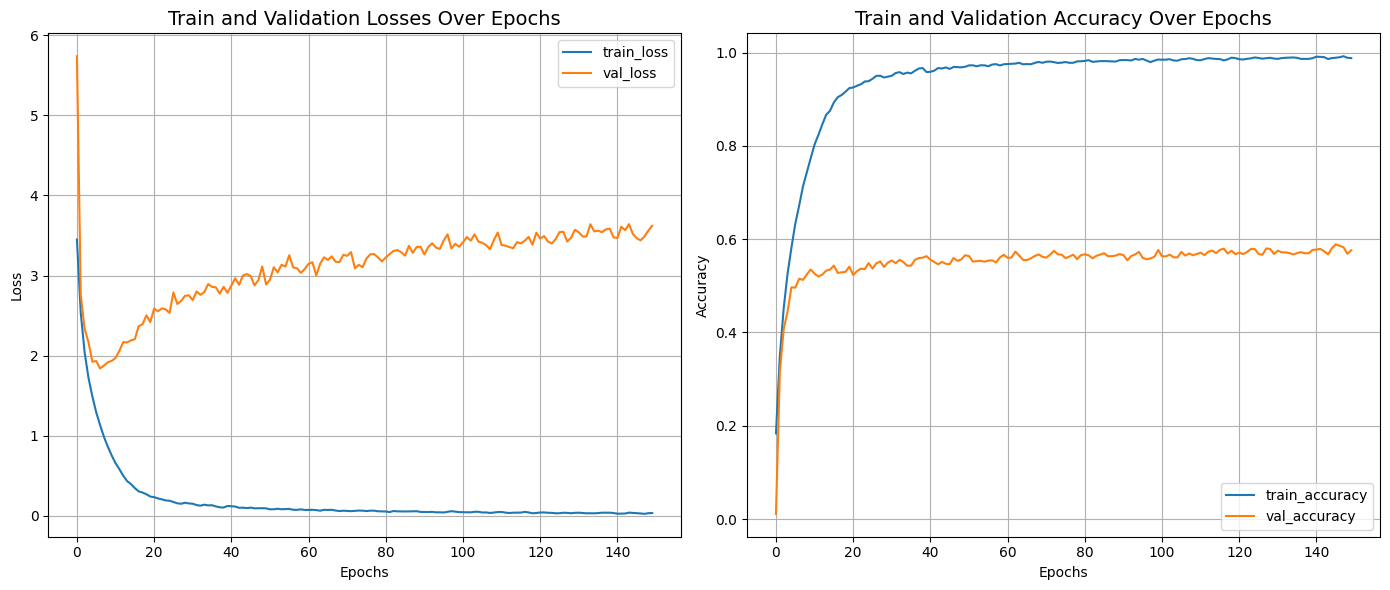

In [9]:
# 損失（loss）のプロット
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()

# 正解率（accuracy）のプロット
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


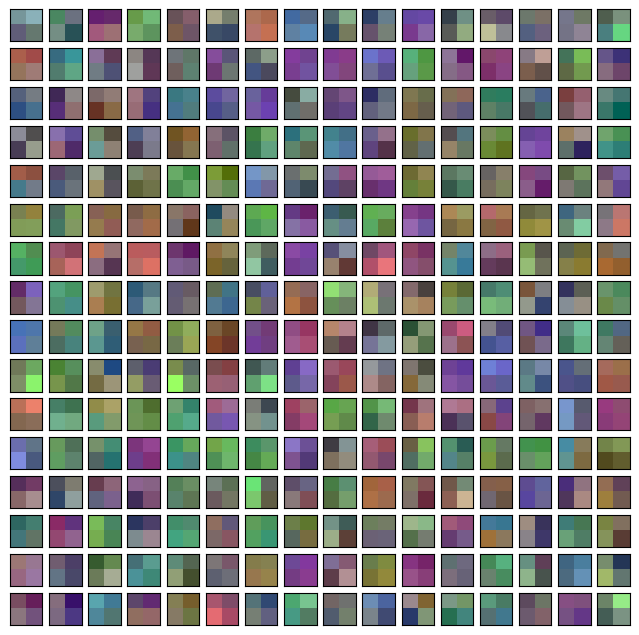

In [10]:
def visualization_plot(weights, idx=1):
    """ 重みを画像としてプロットする

    """
    # 与えられた重みにmin-max正規化を適用
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # すべてのフィルターを視覚化する
    num_filters = 256  # 使用するフィルターの数を設定
    plt.figure(figsize=(8, 8))  # 図のサイズを設定

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]  # 各フィルターの重みを取得
        if current_weight.shape[-1] == 1:  # チャンネル次元が1の場合、次元を削除
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)  # 16x16のグリッドでサブプロットを作成
        ax.set_xticks([])  # x軸の目盛りを非表示にする
        ax.set_yticks([])  # y軸の目盛りを非表示にする
        plt.imshow(current_weight)  # フィルターの重みを画像として表示
        idx += 1  # インデックスを更新

# ConvMixerモデルの第3層（ステムブロックconv_stem）の学習された重みを取得
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)  # パッチエンベッディングを視覚化する関数を呼び出し


5 <DepthwiseConv2D name=depthwise_conv2d, built=True>
12 <DepthwiseConv2D name=depthwise_conv2d_1, built=True>
19 <DepthwiseConv2D name=depthwise_conv2d_2, built=True>
26 <DepthwiseConv2D name=depthwise_conv2d_3, built=True>
33 <DepthwiseConv2D name=depthwise_conv2d_4, built=True>
40 <DepthwiseConv2D name=depthwise_conv2d_5, built=True>
47 <DepthwiseConv2D name=depthwise_conv2d_6, built=True>
54 <DepthwiseConv2D name=depthwise_conv2d_7, built=True>


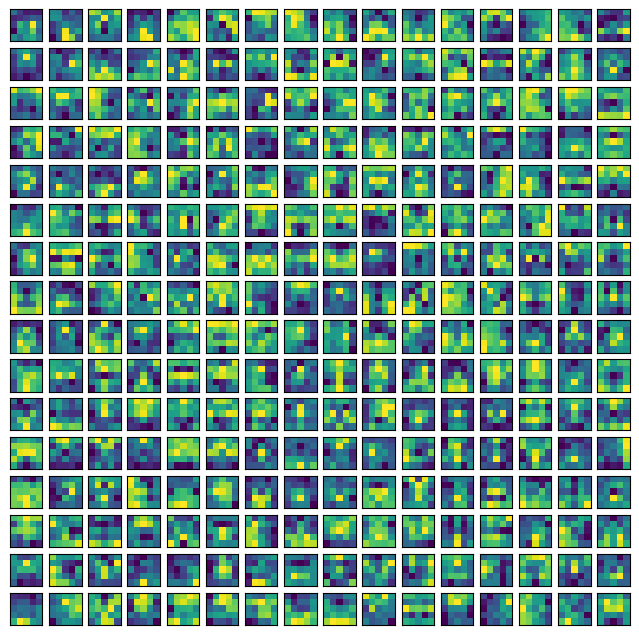

In [11]:
# ConvMixerモデル内のPointwise畳み込みでない畳み込み層のインデックスを出力する
for i, layer in enumerate(conv_mixer_model.layers):
    # 現在のレイヤーがDepthwiseConv2Dレイヤーであるかどうかを確認
    if isinstance(layer, layers.DepthwiseConv2D):
        # レイヤーのカーネルサイズが(5, 5)であるかどうかを確認
        if layer.get_config()["kernel_size"] == (5, 5):
            # 該当するレイヤーのインデックスとレイヤー自体を出力
            print(i, layer)

# ネットワークの中間にあるカーネルを選択（ここでは26番目のレイヤーを選択）
idx = 26
# 指定されたインデックスのレイヤーからカーネルを取得
kernel = conv_mixer_model.layers[idx].get_weights()[0]
# カーネルの形状を調整して視覚化に適した形にする
kernel = np.expand_dims(kernel.squeeze(), axis=2)
# カーネルを視覚化する関数を呼び出し
visualization_plot(kernel)
